<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260129_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 0. 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# 1. 데이터 생성 클래스 (지수항 통일 및 Deterministic Noise)
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.001):
        self.L, self.nu = L, nu

    # [공통] 감쇠 함수 (신호와 노이즈 비율 유지)
    def get_decay(self, t):
        k = 1
        return np.exp(-2 * (k * np.pi)**2 * self.nu * t)

    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = self.get_decay(t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * (decay**2)
        return u, v, p

    def get_unphysical_noise(self, X, Y, t):
        # 결정론적 노이즈 (함수 형태이므로 임의의 t에 대해 생성 가능)
        decay = self.get_decay(t)
        noise_scale = 0.1 * self.get_decay(t)
        u_n = noise_scale * np.sin(8 * np.pi * X / self.L) * np.sin(8 * np.pi * Y / self.L)
        v_n = noise_scale * np.cos(8 * np.pi * X / self.L) * np.cos(8 * np.pi * Y / self.L)
        p_n = (decay**2) * 0.1 * 0.25 * (np.sin(4 * np.pi * X / self.L))
        return u_n, v_n, p_n

    def get_data_at_t(self, nx, ny, t_val):
        x, y = np.linspace(0, self.L, nx), np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_n, v_n, p_n = self.get_unphysical_noise(X, Y, t_val)

        # LF = HF + Noise
        u_lf, v_lf, p_lf = u_hf + u_n, v_hf + v_n, p_hf + p_n

        return X, Y, u_lf, v_lf, p_lf, u_hf, v_hf, p_hf

# 2. 데이터셋 구성 (입력에 LF 포함)
L_val, nu_val, GRID = 4.0, 0.01, 100
T_max_train = 10.0
T_scale = 13.0 # 정규화 상수
generator = FluidGenerator(L=L_val, nu=nu_val)
train_times = np.linspace(0, T_max_train, 11) # 0, 1, ..., 10

# 리스트 초기화
x_list, y_list, t_list = [], [], []
u_lf_list, v_lf_list, p_lf_list = [], [], [] # [NEW] 입력으로 사용될 LF
u_hf_list, v_hf_list, p_hf_list = [], [], [] # [NEW] 타겟으로 사용될 HF

print("Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...")
for t in train_times:
    X, Y, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t)

    x_list.append(X.flatten())
    y_list.append(Y.flatten())
    t_list.append(np.full(X.size, t))

    # LF를 입력(Feature)으로 저장
    u_lf_list.append(u_l.flatten())
    v_lf_list.append(v_l.flatten())
    p_lf_list.append(p_l.flatten())

    # HF를 정답(Target)으로 저장
    u_hf_list.append(u_h.flatten())
    v_hf_list.append(v_h.flatten())
    p_hf_list.append(p_h.flatten())

# 텐서 변환
# 1. 좌표 입력
x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list)/T_scale, dtype=torch.float32).view(-1, 1).to(device)

# 2. LF 유동장 입력 (Input Features)
u_lf_train = torch.tensor(np.concatenate(u_lf_list), dtype=torch.float32).view(-1, 1).to(device)
v_lf_train = torch.tensor(np.concatenate(v_lf_list), dtype=torch.float32).view(-1, 1).to(device)
p_lf_train = torch.tensor(np.concatenate(p_lf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. HF 유동장 타겟 (Labels)
u_hf_train = torch.tensor(np.concatenate(u_hf_list), dtype=torch.float32).view(-1, 1).to(device)
v_hf_train = torch.tensor(np.concatenate(v_hf_list), dtype=torch.float32).view(-1, 1).to(device)
p_hf_train = torch.tensor(np.concatenate(p_hf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. 모델 정의 (입력 차원 증가: 3 -> 6)
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=4.0):
        super().__init__()
        # 좌표(x,y,t)에 대해서만 Fourier Feature를 적용하는 것이 일반적이나,
        # 여기서는 전체 입력 6개에 대해 적용하거나, 좌표만 적용 후 LF는 concat할 수 있습니다.
        # 간단하고 강력한 성능을 위해 6개 채널 모두 임베딩하거나,
        # 좌표 3개만 임베딩하고 나머지는 그냥 붙이는 방식을 씁니다.
        # 여기서는 "좌표(3) 임베딩 + LF(3) 원본" 구조를 추천합니다. (물리적 위치 정보 강조)
        self.register_buffer("B", torch.randn(3, 128) * scale) # 좌표용 B

    def forward(self, coords, fields):
        # coords: x, y, t
        # fields: u_lf, v_lf, p_lf
        x_proj = 2 * np.pi * coords @ self.B
        emb = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        # 임베딩된 좌표 특징과 원본 LF 값을 결합
        return torch.cat([emb, fields], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3) # 좌표 3개 임베딩
        # 입력 크기: (128*2) + 3(LF fields) = 259
        self.net = nn.Sequential(
            nn.Linear(256 + 3, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3) # Output: HF correction
        )
    def forward(self, x, y, t, u_lf, v_lf, p_lf):
        coords = torch.cat([x, y, t], dim=1)
        fields = torch.cat([u_lf, v_lf, p_lf], dim=1)
        return self.net(self.embedding(coords, fields))

# 4. Phase 0: Warm-up (Supervised Learning: LF input -> HF output)
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("\n--- Phase 0: Warm-up (Learning to map LF to HF) ---")
for epoch in range(1501):
    optimizer.zero_grad()
    # 입력으로 LF 데이터도 함께 줍니다.
    pred = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)

    # 타겟은 HF 데이터입니다.
    loss = torch.mean((pred[:,0:1]-u_hf_train)**2 + \
                      (pred[:,1:2]-v_hf_train)**2 + \
                      (pred[:,2:3]-p_hf_train)**2)

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
      print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if loss.item() < 0.0005:
      print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
      break

torch.save(model.state_dict(), "warmup_model.pth")

Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...

--- Phase 0: Warm-up (Learning to map LF to HF) ---
Epoch 0 | Loss: 0.158489
Epoch 50 | Loss: 0.023897
Epoch 100 | Loss: 0.009290
Epoch 150 | Loss: 0.001531
Epoch 200 | Loss: 0.000567
Epoch 210 | Loss: 0.000496


Loading Data for Phase 1 (0 ~ 10.0s)...
>> Success: Loaded 'warmup_model.pth' from Cell 1.

--- Phase 1: Physics Training (0~10s) ---
Ep 0 | Total: 0.44220 | Data: 0.02762 | PDE: 0.41458
Ep 500 | Total: 0.06377 | Data: 0.01962 | PDE: 0.04415
Ep 1000 | Total: 0.02209 | Data: 0.00426 | PDE: 0.01783
Ep 1500 | Total: 0.01016 | Data: 0.00167 | PDE: 0.00849
Ep 2000 | Total: 0.00569 | Data: 0.00096 | PDE: 0.00472

=== Starting Method 1: Time-Marching Loop ===

>>> Extending Horizon: 10.0s ~ 10.5s
--> Data updated. Total training points: 112000
--> Re-training on range 0 ~ 10.5s ...
   [Fine-tune Ep 0] Loss: 0.007236
   [Fine-tune Ep 500] Loss: 0.003818
   [Fine-tune Ep 1000] Loss: 0.002590

>>> Extending Horizon: 10.5s ~ 11.0s
--> Data updated. Total training points: 114000
--> Re-training on range 0 ~ 11.0s ...
   [Fine-tune Ep 0] Loss: 0.003634
   [Fine-tune Ep 500] Loss: 0.002069
   [Fine-tune Ep 1000] Loss: 0.001510

>>> Extending Horizon: 11.0s ~ 11.5s
--> Data updated. Total training po

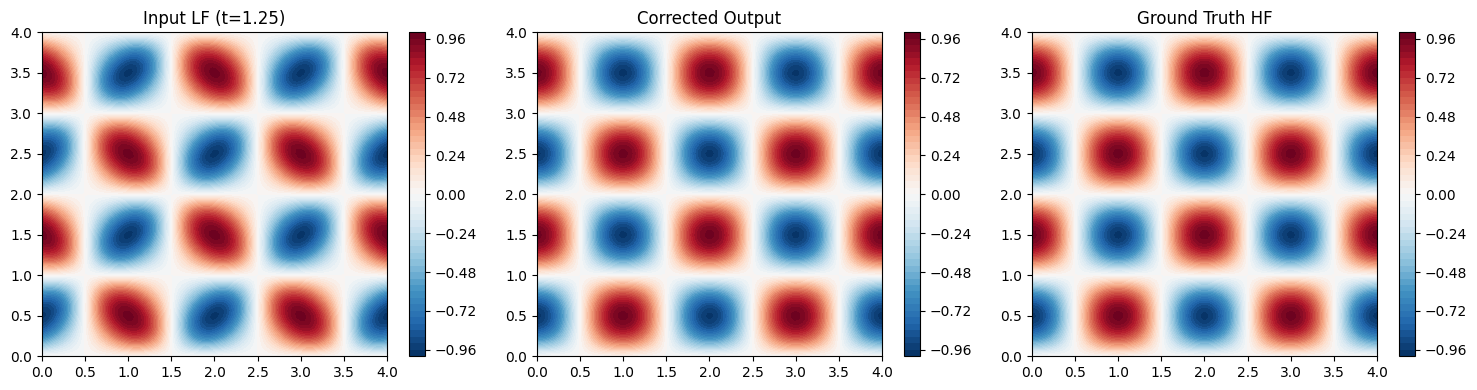


[Extrapolation (t=2.5)] Time t=2.5
Input MSE (LF vs HF): 0.00221997
Output MSE (Pred vs HF): 0.00000287


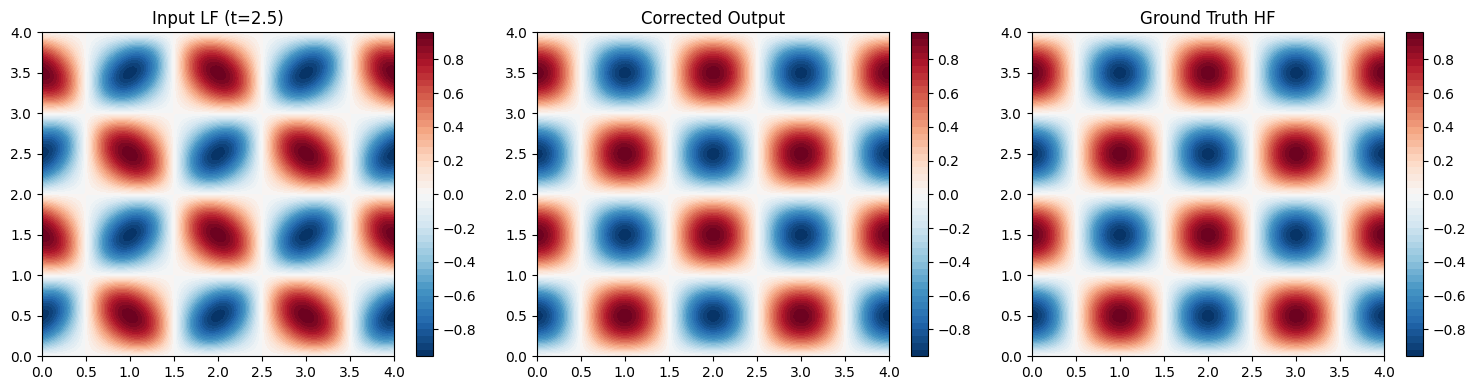


[Extrapolation (t=7.3)] Time t=7.3
Input MSE (LF vs HF): 0.00183675
Output MSE (Pred vs HF): 0.00000510


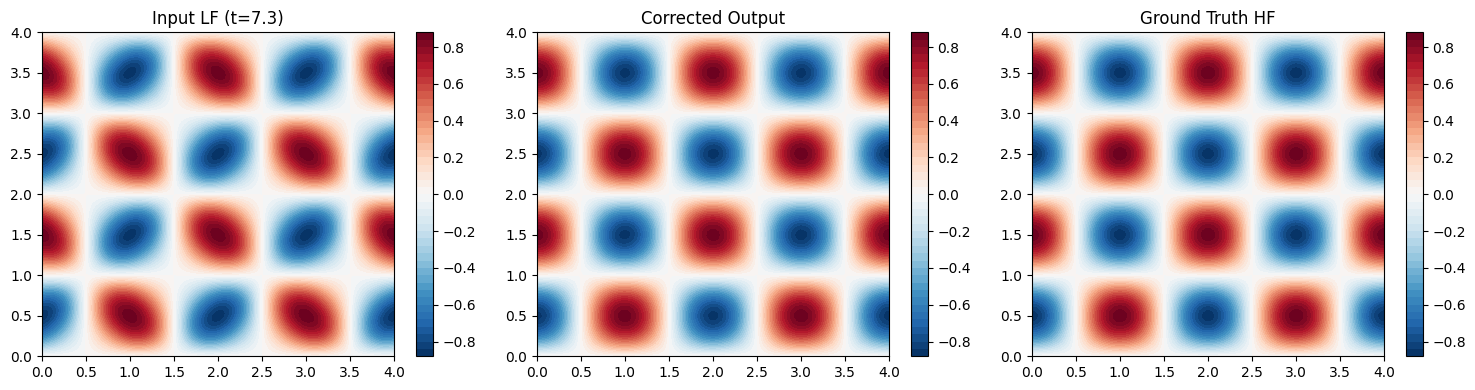


[Extrapolation (t=9.5)] Time t=9.5
Input MSE (LF vs HF): 0.00168395
Output MSE (Pred vs HF): 0.00000861


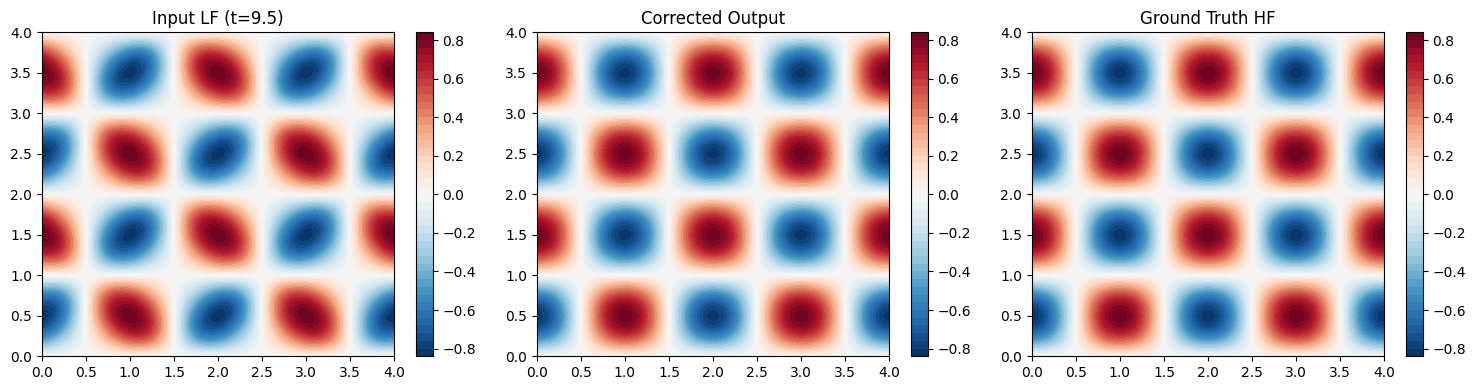


[Extrapolation (t=11.5)] Time t=11.5
Input MSE (LF vs HF): 0.00155611
Output MSE (Pred vs HF): 0.00007911


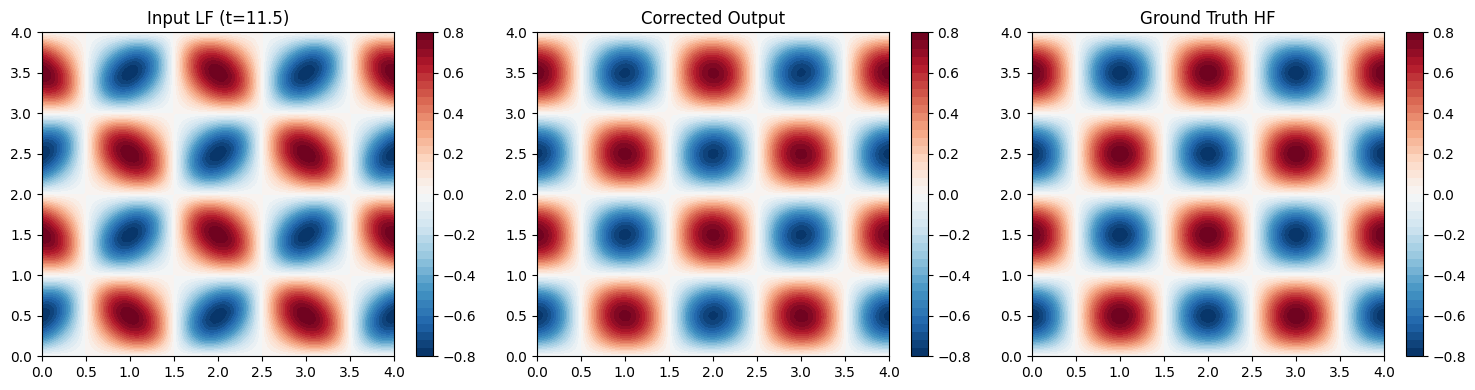


[Extrapolation (t=13.0)] Time t=13.0
Input MSE (LF vs HF): 0.00146663
Output MSE (Pred vs HF): 0.00006323


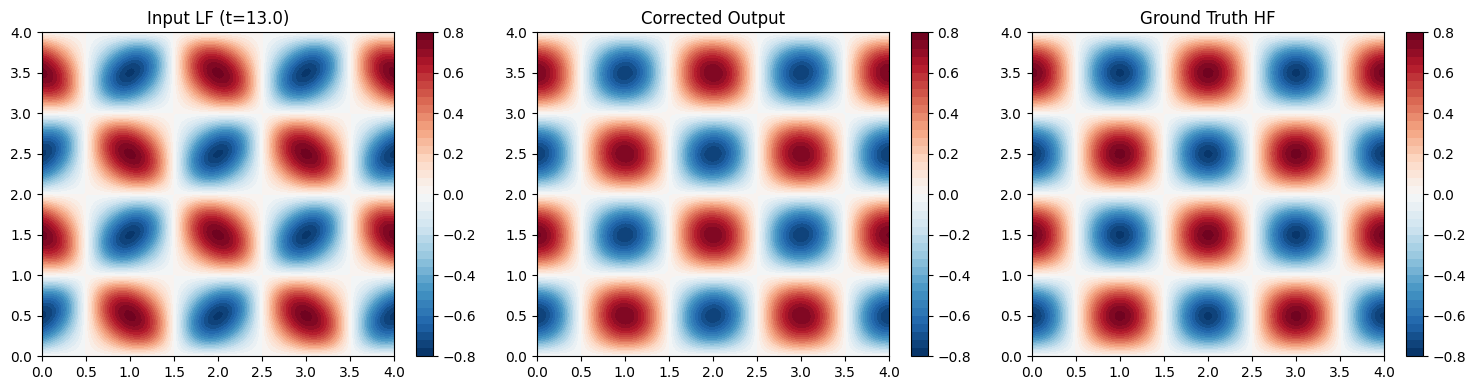


[Extrapolation (t=15.0)] Time t=15.0
Input MSE (LF vs HF): 0.00135529
Output MSE (Pred vs HF): 0.00007241


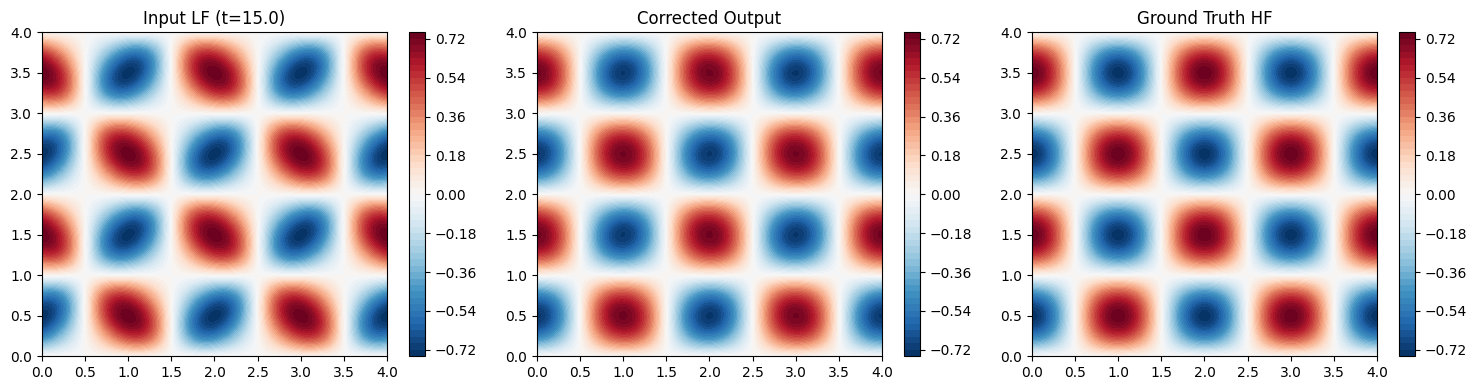


[Extrapolation (t=20.0)] Time t=20.0
Input MSE (LF vs HF): 0.00111251
Output MSE (Pred vs HF): 0.00009552


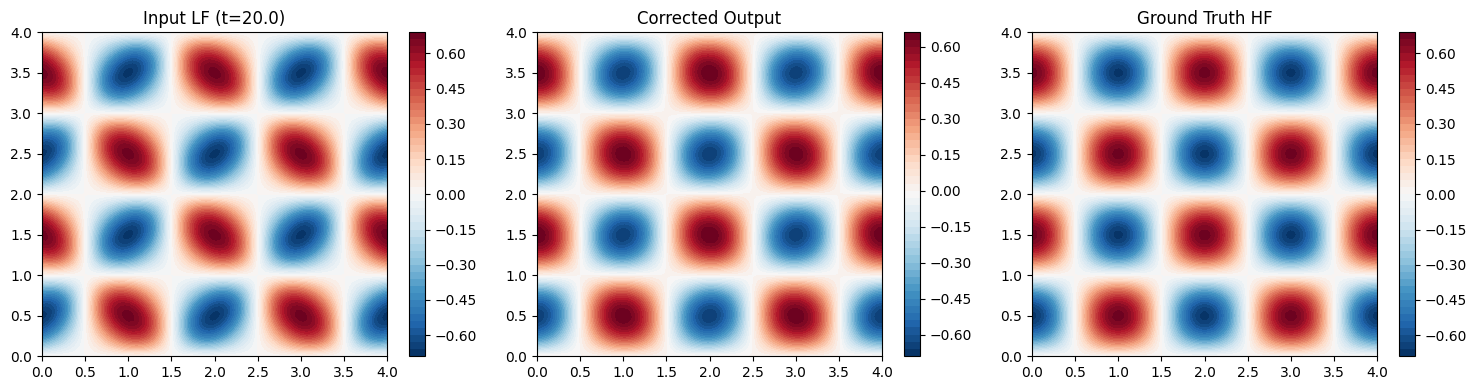


[Extrapolation (t=25.0)] Time t=25.0
Input MSE (LF vs HF): 0.00091323
Output MSE (Pred vs HF): 0.00011968


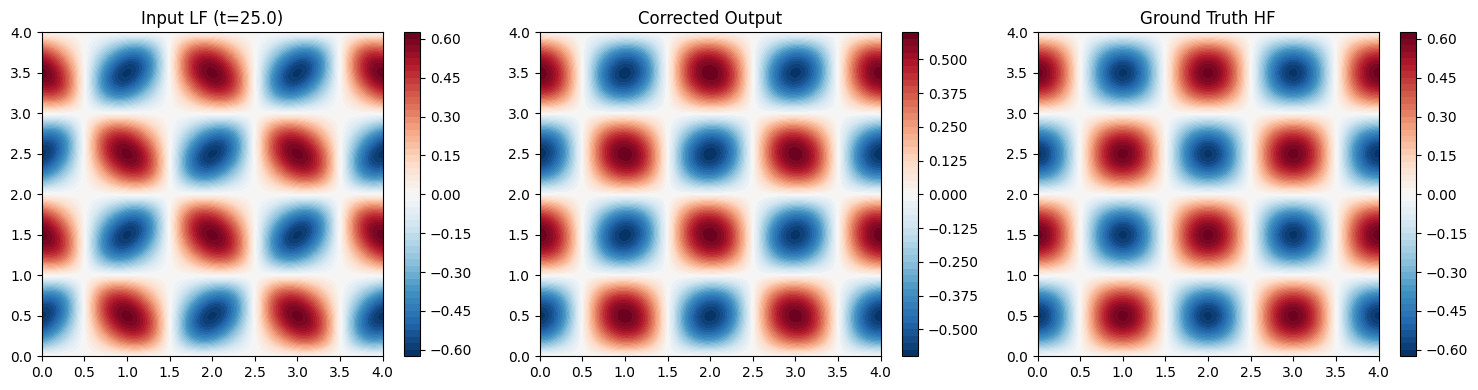


[Extrapolation (t=30.0)] Time t=30.0
Input MSE (LF vs HF): 0.00074964
Output MSE (Pred vs HF): 0.00015613


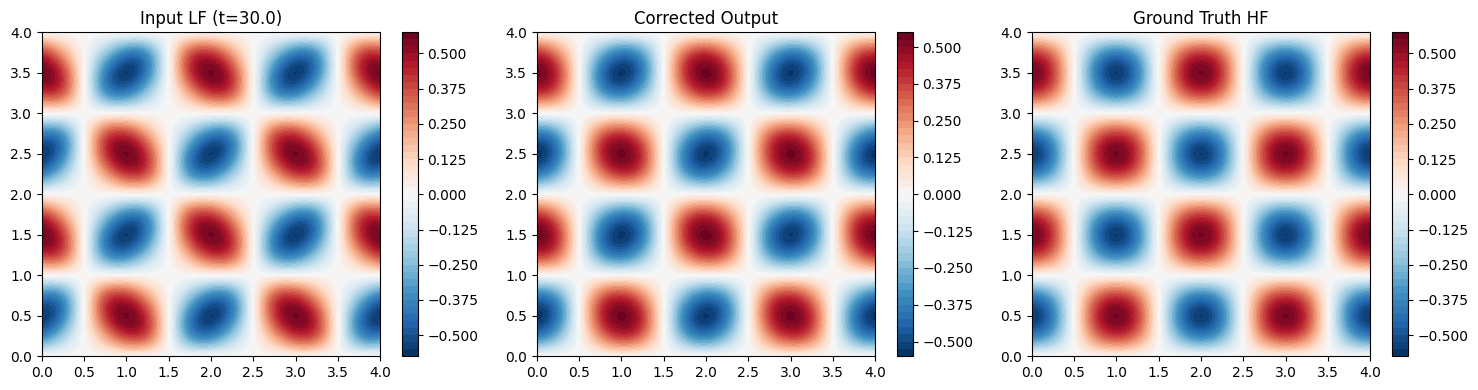

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 파라미터 설정 (셀 1과 동일하게 유지)
L_val = 4.0
nu_val = 0.001
T_scale = 13.0
GRID = 100
T_train_max = 10.0

# 데이터 생성기 인스턴스
generator = FluidGenerator(L=L_val, nu=nu_val)

# ---------------------------------------------------------
# 1. 학습 데이터셋 다시 로드 (0 ~ 10초)
#    (셀 1의 변수를 그대로 쓸 수도 있지만, 독립 실행을 위해 다시 로드합니다)
# ---------------------------------------------------------
train_times = np.linspace(0, T_train_max, 11) # 0, 1, ..., 10

x_list, y_list, t_list = [], [], []
u_lf_list, v_lf_list, p_lf_list = [], [], []
u_hf_list, v_hf_list, p_hf_list = [], [], []

print(f"Loading Data for Phase 1 (0 ~ {T_train_max}s)...")
for t in train_times:
    X, Y, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t)

    x_list.append(X.flatten())
    y_list.append(Y.flatten())
    t_list.append(np.full(X.size, t))

    u_lf_list.append(u_l.flatten())
    v_lf_list.append(v_l.flatten())
    p_lf_list.append(p_l.flatten())

    u_hf_list.append(u_h.flatten())
    v_hf_list.append(v_h.flatten())
    p_hf_list.append(p_h.flatten())

# 텐서 변환
x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list)/T_scale, dtype=torch.float32).view(-1, 1).to(device)

u_lf_train = torch.tensor(np.concatenate(u_lf_list), dtype=torch.float32).view(-1, 1).to(device)
v_lf_train = torch.tensor(np.concatenate(v_lf_list), dtype=torch.float32).view(-1, 1).to(device)
p_lf_train = torch.tensor(np.concatenate(p_lf_list), dtype=torch.float32).view(-1, 1).to(device)

u_hf_train = torch.tensor(np.concatenate(u_hf_list), dtype=torch.float32).view(-1, 1).to(device)
v_hf_train = torch.tensor(np.concatenate(v_hf_list), dtype=torch.float32).view(-1, 1).to(device)
p_hf_train = torch.tensor(np.concatenate(p_hf_list), dtype=torch.float32).view(-1, 1).to(device)

# ---------------------------------------------------------
# 2. 물리 식(PDE Loss) 정의
# ---------------------------------------------------------
def get_pde_loss(model, x, y, t, u_lf_in, v_lf_in, p_lf_in, nu, L, T_scale):
    out = model(x, y, t, u_lf_in, v_lf_in, p_lf_in)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs, torch.ones_like(outputs), create_graph=True)[0]

    u_t = grad(u, t) / T_scale
    v_t = grad(v, t) / T_scale
    u_x_raw, u_y_raw = grad(u, x), grad(u, y)
    v_x_raw, v_y_raw = grad(v, x), grad(v, y)
    p_x_raw, p_y_raw = grad(p, x), grad(p, y)

    u_x, u_y = u_x_raw/L, u_y_raw/L
    v_x, v_y = v_x_raw/L, v_y_raw/L
    p_x, p_y = p_x_raw/L, p_y_raw/L

    u_xx, u_yy = grad(u_x_raw, x)/(L**2), grad(u_y_raw, y)/(L**2)
    v_xx, v_yy = grad(v_x_raw, x)/(L**2), grad(v_y_raw, y)/(L**2)

    f_mass = u_x + v_y
    f_u = u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)

    return torch.mean(f_mass**2), torch.mean(f_u**2 + f_v**2)

# ---------------------------------------------------------
# 3. 모델 로드 및 Phase 1 학습 (Data + PDE, 0~10초)
# ---------------------------------------------------------
clear_memory()
model = PINN().to(device)

# [수정됨] 셀 1에서 저장한 모델 불러오기 (중복 학습 방지)
try:
    model.load_state_dict(torch.load("warmup_model.pth"))
    print(">> Success: Loaded 'warmup_model.pth' from Cell 1.")
except FileNotFoundError:
    print(">> Warning: 'warmup_model.pth' not found. Starting with random weights.")

# Phase 1: Physics Training (0~10s)
# 셀 1은 단순히 데이터 매핑만 했으므로,
# 외삽(Time-Marching)을 하기 전에 물리 법칙(PDE)을 0~10초 구간에 확실히 주입해야 합니다.
print("\n--- Phase 1: Physics Training (0~10s) ---")
optimizer = optim.Adam(model.parameters(), lr=1e-4)

t_p_max = T_train_max

for epoch in range(2001): # PDE 학습
    optimizer.zero_grad()

    # Random Sampling for PDE (Collocation Points)
    N_p = 5000
    x_rand = torch.rand(N_p, 1, device=device).requires_grad_(True)
    y_rand = torch.rand(N_p, 1, device=device).requires_grad_(True)
    t_rand = torch.rand(N_p, 1, device=device).requires_grad_(True) * (t_p_max / T_scale)

    # LF Inputs for PDE calculation
    with torch.no_grad():
        x_np = x_rand.detach().cpu().numpy() * L_val
        y_np = y_rand.detach().cpu().numpy() * L_val
        t_np = t_rand.detach().cpu().numpy() * T_scale

        # PDE 손실 계산을 위한 LF 입력값 생성 (Noise 포함)
        u_h, v_h, p_h = generator.get_tgv_solution(x_np, y_np, t_np)
        u_n, v_n, p_n = generator.get_unphysical_noise(x_np, y_np, t_np)

        u_lf_in = torch.tensor(u_h + u_n, dtype=torch.float32).to(device)
        v_lf_in = torch.tensor(v_h + v_n, dtype=torch.float32).to(device)
        p_lf_in = torch.tensor(p_h + p_n, dtype=torch.float32).to(device)

    # 1. Data Loss (기존 0~10초 정답 데이터)
    pred_data = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
    l_data = torch.mean((pred_data[:,0:1]-u_hf_train)**2 + (pred_data[:,1:2]-v_hf_train)**2 + (pred_data[:,2:3]-p_hf_train)**2)

    # 2. PDE Loss (물리 법칙)
    l_mass, l_mom = get_pde_loss(model, x_rand, y_rand, t_rand, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)

    # Loss 합산
    total_loss = l_data + (l_mass + l_mom)
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Ep {epoch} | Total: {total_loss.item():.5f} | Data: {l_data.item():.5f} | PDE: {l_mass.item()+l_mom.item():.5f}")

# ---------------------------------------------------------
# [방식 1 핵심] Time-Marching Loop (10초 ~ )
# ---------------------------------------------------------
print("\n==============================================")
print("=== Starting Method 1: Time-Marching Loop ===")
print("==============================================")

current_t = 10.0
final_t = 30.0 # 원하는 시간까지
dt = 0.5       # 스텝 크기

# 재학습용 Optimizer (Fine-tuning이므로 LR을 조금 낮춤)
optimizer_tm = optim.Adam(model.parameters(), lr=5e-5)

while current_t < final_t:
    next_t = current_t + dt
    print(f"\n>>> Extending Horizon: {current_t}s ~ {next_t}s")

    # -------------------------------------------------
    # 1. 예측 (Prediction as Pseudo-Label)
    # -------------------------------------------------
    # 다음 스텝(예: 11초)의 그리드 데이터 가져오기 (입력용 LF만 사용)
    X_new, Y_new, u_l, v_l, p_l, _, _, _ = generator.get_data_at_t(GRID, GRID, next_t)

    # 텐서 변환
    x_new_ts = torch.tensor(X_new.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_new_ts = torch.tensor(Y_new.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_new_ts = torch.tensor(np.full(x_new_ts.shape, next_t/T_scale), dtype=torch.float32).view(-1, 1).to(device)

    u_lf_new = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    v_lf_new = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    p_lf_new = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    # 현재 모델로 HF 예측 수행
    model.eval()
    with torch.no_grad():
        out = model(x_new_ts, y_new_ts, t_new_ts, u_lf_new, v_lf_new, p_lf_new)
        u_pred_new = out[:, 0:1]
        v_pred_new = out[:, 1:2]
        p_pred_new = out[:, 2:3]

    # -------------------------------------------------
    # 2. 데이터 업데이트 (Self-Training Data Injection)
    # -------------------------------------------------
    # 전체 포인트를 다 넣으면 메모리가 부족할 수 있으므로 2000개만 랜덤 샘플링하여 추가
    idx = torch.randperm(x_new_ts.size(0))[:2000]

    # 기존 학습 데이터(x_train 등)에 새로운 예측 데이터를 추가(concatenation)
    x_train = torch.cat([x_train, x_new_ts[idx]], dim=0)
    y_train = torch.cat([y_train, y_new_ts[idx]], dim=0)
    t_train = torch.cat([t_train, t_new_ts[idx]], dim=0)

    u_lf_train = torch.cat([u_lf_train, u_lf_new[idx]], dim=0)
    v_lf_train = torch.cat([v_lf_train, v_lf_new[idx]], dim=0)
    p_lf_train = torch.cat([p_lf_train, p_lf_new[idx]], dim=0)

    # [핵심] 정답(Label) 자리에 모델이 방금 예측한 값(Pseudo-Label)을 넣습니다.
    u_hf_train = torch.cat([u_hf_train, u_pred_new[idx]], dim=0)
    v_hf_train = torch.cat([v_hf_train, v_pred_new[idx]], dim=0)
    p_hf_train = torch.cat([p_hf_train, p_pred_new[idx]], dim=0)

    print(f"--> Data updated. Total training points: {x_train.size(0)}")

    # -------------------------------------------------
    # 3. 재학습 (Fine-tuning)
    # -------------------------------------------------
    model.train()
    t_p_max = next_t # PDE 샘플링 범위를 확장된 시간까지 늘림

    print(f"--> Re-training on range 0 ~ {next_t}s ...")
    # 짧은 에포크(예: 1000회) 동안 미세 조정
    for epoch in range(1001):
        optimizer_tm.zero_grad()

        # PDE Collocation Points (0 ~ 현재 시간 전체 범위에서 샘플링)
        t_rand = torch.rand(5000, 1, device=device).requires_grad_(True) * (t_p_max / T_scale)
        x_rand = torch.rand(5000, 1, device=device).requires_grad_(True)
        y_rand = torch.rand(5000, 1, device=device).requires_grad_(True)

        # PDE용 LF 입력 생성
        with torch.no_grad():
            x_np = x_rand.detach().cpu().numpy() * L_val
            y_np = y_rand.detach().cpu().numpy() * L_val
            t_np = t_rand.detach().cpu().numpy() * T_scale
            u_h, v_h, p_h = generator.get_tgv_solution(x_np, y_np, t_np)
            u_n, v_n, p_n = generator.get_unphysical_noise(x_np, y_np, t_np)

            u_lf_in = torch.tensor(u_h + u_n, dtype=torch.float32).to(device)
            v_lf_in = torch.tensor(v_h + v_n, dtype=torch.float32).to(device)
            p_lf_in = torch.tensor(p_h + p_n, dtype=torch.float32).to(device)

        # Loss 계산
        # 1. Data Loss (과거 정답 + 최근 예측값)
        pred_data = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
        l_data = torch.mean((pred_data[:,0:1]-u_hf_train)**2 + (pred_data[:,1:2]-v_hf_train)**2 + (pred_data[:,2:3]-p_hf_train)**2)

        # 2. PDE Loss (물리 보정)
        l_mass, l_mom = get_pde_loss(model, x_rand, y_rand, t_rand, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)

        loss = l_data + (l_mass + l_mom)
        loss.backward()
        optimizer_tm.step()

        if epoch % 500 == 0:
            print(f"   [Fine-tune Ep {epoch}] Loss: {loss.item():.6f}")

    # 시간 전진
    current_t = next_t

print("\n=== Time-Marching Complete ===")

# 결과 확인 함수 (동일)
def test_correction(test_t, scenario_name):
    X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, test_t)

    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, test_t/T_scale), dtype=torch.float32).view(-1, 1).to(device)

    u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
        u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

    mse_lf = np.mean((u_l - u_h)**2)
    mse_pinn = np.mean((u_pred - u_h)**2)

    print(f"\n[{scenario_name}] Time t={test_t}")
    print(f"Input MSE (LF vs HF): {mse_lf:.8f}")
    print(f"Output MSE (Pred vs HF): {mse_pinn:.8f}")

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.title(f"Input LF (t={test_t})"); plt.contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 2); plt.title("Corrected Output"); plt.contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 3); plt.title("Ground Truth HF"); plt.contourf(X_g, Y_g, u_h, 50, cmap='RdBu_r'); plt.colorbar()
    plt.tight_layout(); plt.show()

# 테스트 실행
test_correction(1.25, "Interpolation (t=1.25)")
test_correction(2.5, "Extrapolation (t=2.5)")
test_correction(7.3, "Extrapolation (t=7.3)")
test_correction(9.5, "Extrapolation (t=9.5)")
test_correction(11.5, "Extrapolation (t=11.5)")
test_correction(13.0, "Extrapolation (t=13.0)")
test_correction(15.0, "Extrapolation (t=15.0)")
test_correction(20.0, "Extrapolation (t=20.0)")
test_correction(25.0, "Extrapolation (t=25.0)")
test_correction(30.0, "Extrapolation (t=30.0)")

Starting evaluation for range 0s ~ 30s with dt=0.5s...

Time(s)  | Input MSE (LF)  |    Model MSE    | Improvement(%) 
  0.0    |    0.002450     |    0.000006     |     99.74     
  0.5    |    0.002402     |    0.000004     |     99.81     
  1.0    |    0.002355     |    0.000003     |     99.85     
  1.5    |    0.002309     |    0.000003     |     99.86     
  2.0    |    0.002264     |    0.000003     |     99.87     
  2.5    |    0.002220     |    0.000003     |     99.87     
  3.0    |    0.002177     |    0.000002     |     99.89     
  3.5    |    0.002134     |    0.000002     |     99.90     
  4.0    |    0.002092     |    0.000002     |     99.90     
  4.5    |    0.002051     |    0.000002     |     99.89     
  5.0    |    0.002011     |    0.000002     |     99.88     
  5.5    |    0.001972     |    0.000003     |     99.83     
  6.0    |    0.001933     |    0.000004     |     99.77     
  6.5    |    0.001896     |    0.000005     |     99.73     
  7.0    |   

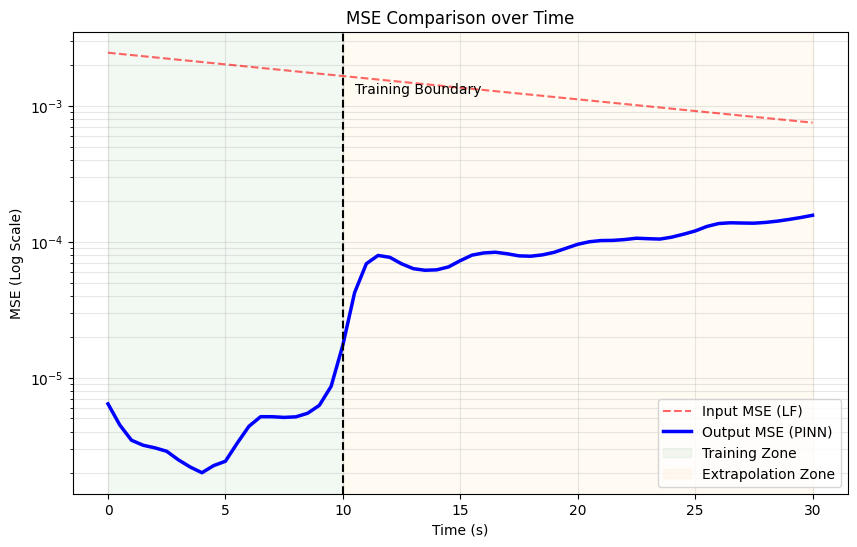

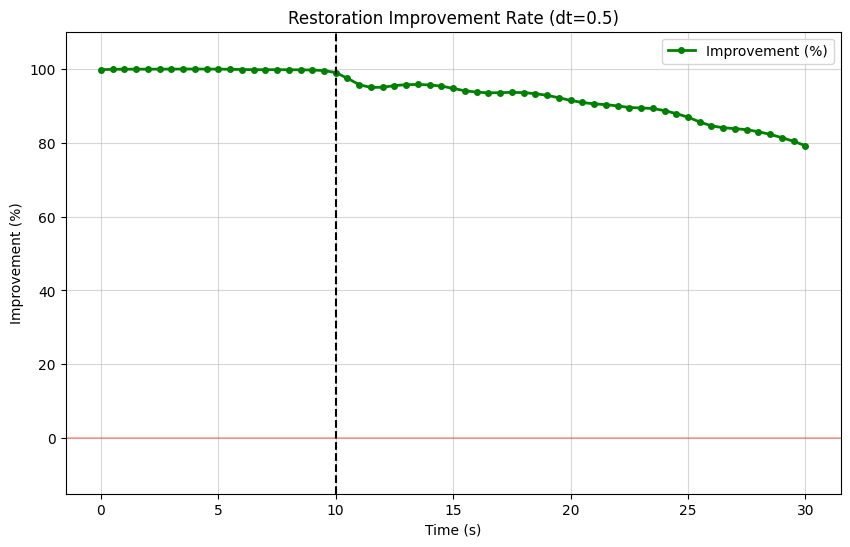

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv

# ==========================================
# 저장 경로 설정
# ==========================================
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def evaluate_and_report():
    print("Starting evaluation for range 0s ~ 30s with dt=0.5s...")

    # -------------------------------------------------------
    # 1. 평가 시간대 설정 (0 ~ 30초, 0.5초 간격)
    # -------------------------------------------------------
    # np.arange(start, stop, step) : stop은 포함되지 않으므로 30.1로 설정
    t_eval = np.arange(0, 30.1, 0.5)

    # 결과 저장용 리스트
    results_data = [] # (time, mse_lf, mse_pinn, improvement)

    model.eval() # 평가 모드

    with torch.no_grad():
        for t_val in t_eval:
            # Data Load
            X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

            # Tensor Conversion
            x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)

            u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

            # Prediction
            out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
            u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

            # Calculate Errors
            mse_lf = np.mean((u_l - u_h)**2)       # Input Noise Level
            mse_pinn = np.mean((u_pred - u_h)**2)  # Model Error

            # Calculate Improvement
            if mse_lf > 1e-15:
                imp = (mse_lf - mse_pinn) / mse_lf * 100
            else:
                imp = 0.0

            results_data.append((t_val, mse_lf, mse_pinn, imp))

    # 리스트 분리 (그래프용)
    times = [r[0] for r in results_data]
    mse_lf_list = [r[1] for r in results_data]
    mse_pinn_list = [r[2] for r in results_data]
    imp_list = [r[3] for r in results_data]

    # -------------------------------------------------------
    # 2. 표 출력 (Console output)
    # -------------------------------------------------------
    print("\n" + "="*65)
    print(f"{'Time(s)':^8} | {'Input MSE (LF)':^15} | {'Model MSE':^15} | {'Improvement(%)':^15}")
    print("="*65)

    for t, m_lf, m_pinn, imp in results_data:
        # Improvement 색상 강조 (콘솔 환경에 따라 다를 수 있음, 여기선 텍스트만)
        mark = ""
        if imp < 0: mark = "(!)" # 성능 저하 시 표시

        print(f"{t:^8.1f} | {m_lf:^15.6f} | {m_pinn:^15.6f} | {imp:^14.2f}{mark}")

        # 구분선 (학습/외삽 경계)
        if t == 10.0:
             print("-" * 65 + " < Training End >")

    print("="*65)

    # -------------------------------------------------------
    # 3. CSV 파일 저장 (Excel용)
    # -------------------------------------------------------
    csv_path = os.path.join(save_dir, "metrics_table.csv")
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Time(s)', 'Input_MSE', 'Model_MSE', 'Improvement_Percentage'])
        writer.writerows(results_data)
    print(f"\n>> Numerical data saved to: {csv_path}")

    # -------------------------------------------------------
    # 4. 그래프 그리기 및 저장
    # -------------------------------------------------------

    # [Graph 1] MSE Log Scale
    plt.figure(figsize=(10, 6))
    plt.plot(times, mse_lf_list, 'r--', label='Input MSE (LF)', alpha=0.6)
    plt.plot(times, mse_pinn_list, 'b-', label='Output MSE (PINN)', linewidth=2.5)

    plt.axvline(x=10, color='k', linestyle='--', linewidth=1.5)
    plt.text(10.5, max(mse_lf_list)*0.5, 'Training Boundary', fontsize=10)
    plt.axvspan(0, 10, color='green', alpha=0.05, label='Training Zone')
    plt.axvspan(10, 30, color='orange', alpha=0.05, label='Extrapolation Zone')

    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('MSE (Log Scale)')
    plt.title('MSE Comparison over Time')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.savefig(os.path.join(save_dir, "mse_comparison.png"), dpi=300)
    plt.show()

    # [Graph 2] Improvement Rate
    plt.figure(figsize=(10, 6))
    plt.plot(times, imp_list, 'g.-', label='Improvement (%)', linewidth=2, markersize=8)

    plt.axvline(x=10, color='k', linestyle='--', linewidth=1.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

    plt.xlabel('Time (s)')
    plt.ylabel('Improvement (%)')
    plt.title(f'Restoration Improvement Rate (dt=0.5)')
    plt.ylim(min(min(imp_list), -10) - 5, 110) # 동적 범위 조절
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.savefig(os.path.join(save_dir, "improvement_rate.png"), dpi=300)
    plt.show()

# 실행
evaluate_and_report()

Starting full evaluation (MSE, Improvement, Relative L2) for range 0s ~ 30s...

Time(s)  |    Input MSE    |    Model MSE    |  Improve(%)  |  Rel. L2 Error 
  0.0    |    0.002450     |    0.000006     |    99.74     |    0.005061    
  0.5    |    0.002402     |    0.000004     |    99.81     |    0.004277    
  1.0    |    0.002355     |    0.000003     |    99.85     |    0.003793    
  1.5    |    0.002309     |    0.000003     |    99.86     |    0.003671    
  2.0    |    0.002264     |    0.000003     |    99.87     |    0.003628    
  2.5    |    0.002220     |    0.000003     |    99.87     |    0.003559    
  3.0    |    0.002177     |    0.000002     |    99.89     |    0.003342    
  3.5    |    0.002134     |    0.000002     |    99.90     |    0.003177    
  4.0    |    0.002092     |    0.000002     |    99.90     |    0.003057    
  4.5    |    0.002051     |    0.000002     |    99.89     |    0.003280    
  5.0    |    0.002011     |    0.000002     |    99.88     | 

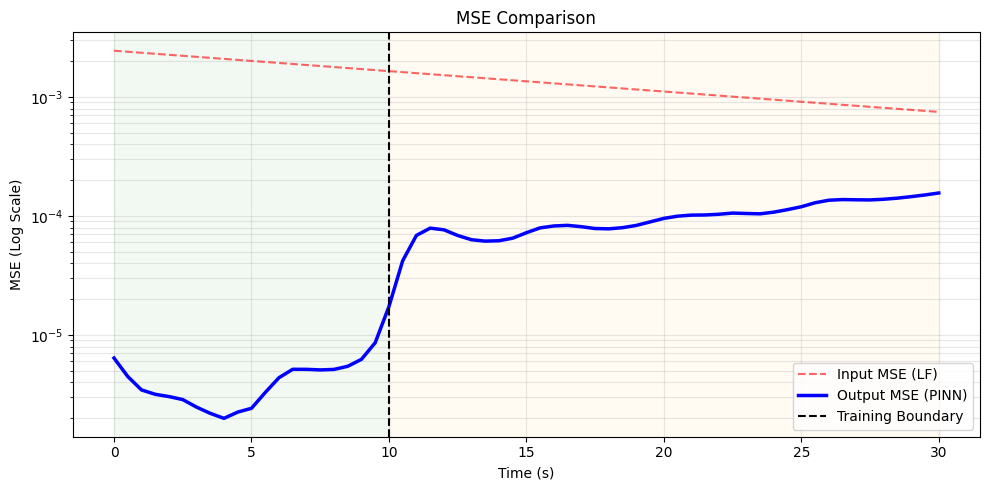

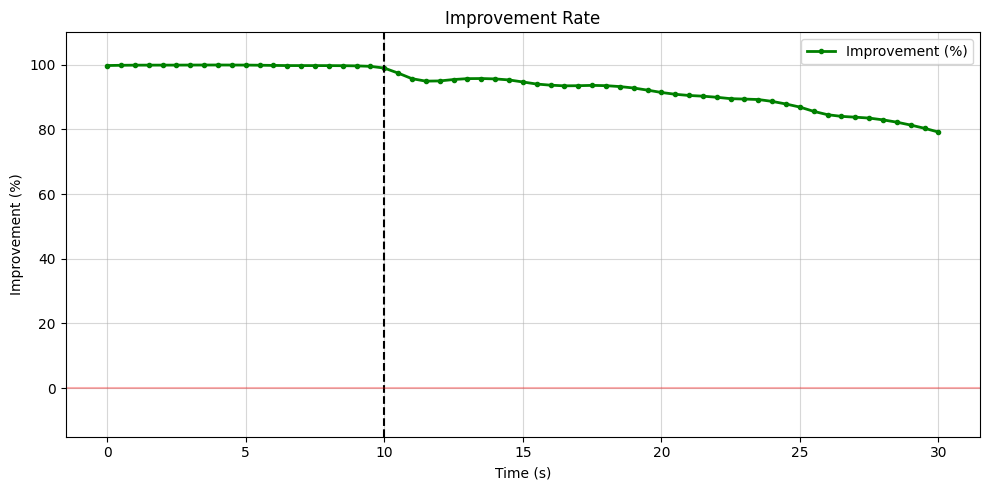

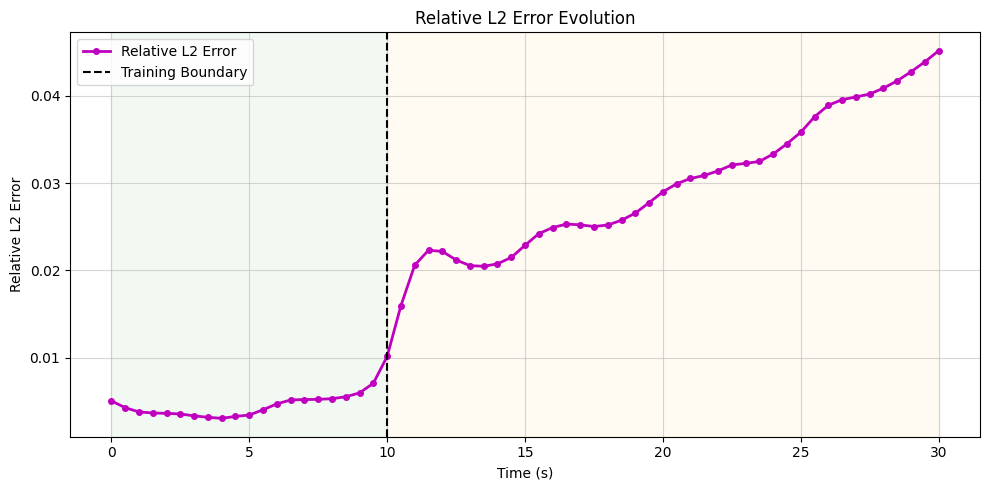

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv

# ==========================================
# 저장 경로 설정
# ==========================================
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def evaluate_full_metrics():
    print("Starting full evaluation (MSE, Improvement, Relative L2) for range 0s ~ 30s...")

    # 평가 시간대 설정 (0 ~ 30초, 0.5초 간격)
    t_eval = np.arange(0, 30.1, 0.5)

    # 결과 저장용 리스트
    # (time, mse_lf, mse_pinn, imp, rel_l2)
    results_data = []

    model.eval()

    with torch.no_grad():
        for t_val in t_eval:
            # 1. 데이터 로드
            X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

            # 2. 텐서 변환
            x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)

            u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

            # 3. 모델 예측
            out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
            u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

            # 4. 지표 계산

            # (A) MSE
            mse_lf = np.mean((u_l - u_h)**2)       # Input MSE
            mse_pinn = np.mean((u_pred - u_h)**2)  # Model MSE

            # (B) Improvement (%)
            if mse_lf > 1e-15:
                imp = (mse_lf - mse_pinn) / mse_lf * 100
            else:
                imp = 0.0

            # (C) Relative L2 Error
            # Norm L2 = sqrt(sum(x^2))
            norm_true = np.linalg.norm(u_h)
            norm_error = np.linalg.norm(u_pred - u_h)

            if norm_true > 1e-15:
                rel_l2 = norm_error / norm_true
            else:
                rel_l2 = 0.0

            results_data.append((t_val, mse_lf, mse_pinn, imp, rel_l2))

    # 리스트 분리 (그래프용)
    times = [r[0] for r in results_data]
    mse_lf_list = [r[1] for r in results_data]
    mse_pinn_list = [r[2] for r in results_data]
    imp_list = [r[3] for r in results_data]
    rel_l2_list = [r[4] for r in results_data]

    # -------------------------------------------------------
    # 5. 표 출력 (Console output) - Relative L2 추가
    # -------------------------------------------------------
    print("\n" + "="*85)
    print(f"{'Time(s)':^8} | {'Input MSE':^15} | {'Model MSE':^15} | {'Improve(%)':^12} | {'Rel. L2 Error':^15}")
    print("="*85)

    for t, m_lf, m_pinn, imp, rl2 in results_data:
        mark = ""
        if imp < 0: mark = "(!)"

        print(f"{t:^8.1f} | {m_lf:^15.6f} | {m_pinn:^15.6f} | {imp:^12.2f}{mark} | {rl2:^15.6f}")

        if t == 10.0:
             print("-" * 85 + " < Training End >")

    print("="*85)

    # -------------------------------------------------------
    # 6. CSV 파일 저장
    # -------------------------------------------------------
    csv_path = os.path.join(save_dir, "full_metrics.csv")
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Time(s)', 'Input_MSE', 'Model_MSE', 'Improvement_Percentage', 'Relative_L2_Error'])
        writer.writerows(results_data)
    print(f"\n>> Data saved to: {csv_path}")

    # -------------------------------------------------------
    # 7. 그래프 그리기 (총 3개)
    # -------------------------------------------------------

    # [Graph 1] MSE Comparison
    plt.figure(figsize=(10, 5))
    plt.plot(times, mse_lf_list, 'r--', label='Input MSE (LF)', alpha=0.6)
    plt.plot(times, mse_pinn_list, 'b-', label='Output MSE (PINN)', linewidth=2.5)
    plt.axvline(x=10, color='k', linestyle='--', label='Training Boundary')
    plt.axvspan(0, 10, color='green', alpha=0.05)
    plt.axvspan(10, 30, color='orange', alpha=0.05)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('MSE (Log Scale)')
    plt.title('MSE Comparison')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "graph_mse.png"), dpi=300)
    plt.show()

    # [Graph 2] Improvement Rate
    plt.figure(figsize=(10, 5))
    plt.plot(times, imp_list, 'g.-', label='Improvement (%)', linewidth=2)
    plt.axvline(x=10, color='k', linestyle='--')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xlabel('Time (s)')
    plt.ylabel('Improvement (%)')
    plt.title('Improvement Rate')
    plt.ylim(min(min(imp_list), -10) - 5, 110)
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "graph_improvement.png"), dpi=300)
    plt.show()

    # [Graph 3] Relative L2 Error (New!)
    plt.figure(figsize=(10, 5))
    plt.plot(times, rel_l2_list, 'm-o', label='Relative L2 Error', linewidth=2, markersize=4)

    # 영역 표시
    plt.axvline(x=10, color='k', linestyle='--', label='Training Boundary')
    plt.axvspan(0, 10, color='green', alpha=0.05)
    plt.axvspan(10, 30, color='orange', alpha=0.05)

    plt.xlabel('Time (s)')
    plt.ylabel('Relative L2 Error')
    plt.title('Relative L2 Error Evolution')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "graph_relative_l2.png"), dpi=300)
    plt.show()

# 실행
evaluate_full_metrics()